<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movieLens_binarization/binary_movie_RSCCMM_CF_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

movieLens_binarization/binary_movie_RSCCMM_CF_compare.ipynb

In [ ]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv

In [ ]:
#movielensデータ
data_training = pd.read_csv('100k_Movie_training.csv', header=None)
data_test = pd.read_csv('100k_Movie_test.csv', header=None)
X_movie = data_training.values
test_movie = data_test.values
test_movie = test_movie.astype(np.int64)
test_movie_num, test_movie_num_fact = test_movie.shape
print(X_movie)
print(test_movie)

[[1.  0.  0.5 ... 0.5 0.5 0.5]
 [1.  0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 1.  0.5 0.5]]
[[651 256   0]
 [397 151   1]
 [459 155   0]
 ...
 [169 124   0]
 [613  77   1]
 [620 436   0]]


In [ ]:
#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u

In [ ]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_AVE(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rough_u = RSCCMM(X, C, delta)
    # print(f"各クラスターの要素数: {np.sum(rough_u, axis=1)}")

    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64))
    # print(f"オーバーラップしている要素の数: {n_overlaps}")
    # print(f"オーバーラップしていない要素の数: {X.shape[0] - n_overlaps}")

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score)
    auc_sum += auc

  return auc_sum/roop

print(RSCCMM_CF_AUC_AVE(1, test_movie, X_movie, 5, -7))

0.7088761849477302


In [ ]:
#RCCMM
def RCCMM_CF(X, C, a, b):
  n, m = X.shape
  u = np.zeros((C,n))
  w = np.zeros((C,m))
  s = np.zeros((C,n))
  r = np.zeros((n,m))
  r_ = np.zeros((n,m))

  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  for step in range(100):
    u_old = u.copy()
    u = np.zeros((C,n))

    s = np.log(w) @ X.T

    s_max = s.max(0)
    u = (s >= a * s_max + b).astype(np.float64)
    u /= u.sum(0)

    w = (u @ X) + sys.float_info.epsilon
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(u - u_old).max() == 0:
      break

  if any(u.sum(1) == 0):
    raise Exception('要素数0のクラスター発生')

  r = u.T @ w
  r_ = u.T @ np.log(w)

  return r, r_

In [ ]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RCCMM)
def RCCMM_CF_AUC_AVE(roop, test, X, C, alpha, beta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  auc__sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)
  r__test_score = np.zeros(test_num)
  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, r_ = RCCMM_CF(X, C, alpha, beta)

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]
      r__test_score[j] = r_[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score)
    auc_ = roc_auc_score(test_true, r__test_score)
    auc_sum += auc
    auc__sum += auc_

  return auc_sum/roop, auc__sum/roop

print(RCCMM_CF_AUC_AVE(10, test_movie, X_movie, 30, 1.2, -5))

(0.6938252591897696, 0.6938297752508107)


binary_movie_RSCCMM_HCCMM_compare
roop:  5
C:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
delta_list:  [-6.5 -6.7 -6.9 -7.1 -7.3 -7.5 -7.7 -7.9 -8.1 -8.3 -8.5 -8.7 -8.9]
1 0.6940422547134444 -6.5
2 0.704993001314737 -6.7
3 0.7096716336427543 -7.1000000000000005
4 0.7097752439001214 -6.9
5 0.7085421691950734 -7.1000000000000005
6 0.70685142090069 -7.1000000000000005
7 0.7050407948543855 -6.7
8 0.7072134590367003 -7.1000000000000005
9 0.7029398555344208 -7.300000000000001
10 0.7041059322107104 -7.300000000000001
11 0.7001572639649772 -7.300000000000001
12 0.7017087434327938 -7.300000000000001
13 0.6986901695336917 -6.9
14 0.6994258210195519 -7.300000000000001
15 0.6982324268386018 -7.300000000000001
16 0.6981480556232216 -7.1000000000000005
17 0.6967855389298628 -8.900000000000002
18 0.69776111868395 -7.500000000000001
19 0.6967455336087198 -7.700000000000001
20 0.6975248115572464 -7.300000000000001
21 0.6959217791967491 -7.30000000000000

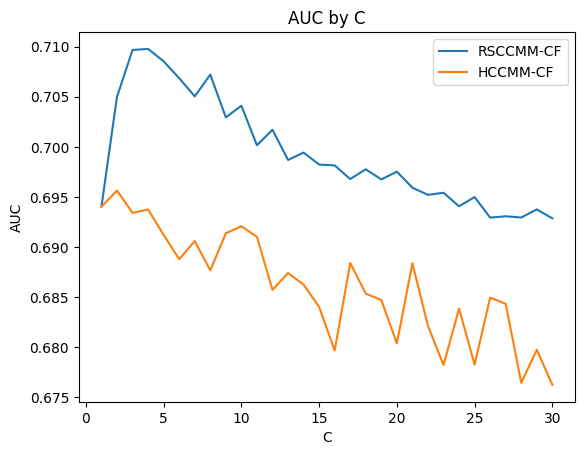

In [ ]:
# 共通設定
name = "binary_movie_RSCCMM_HCCMM_compare"
print(name)
roop = 5
print("roop: ", roop)
x_C = np.arange(1,31,1)
print("C: ", x_C)
output_rows = []
output = [x_C.tolist()]


# RSCCMM-CFの設定
y_RSCCMM_auc_ave = []
delta_list = np.arange(-6.5, -9.1, -0.2)
print("delta_list: ", delta_list )

output_rows.append(["", ', '.join(map(str, x_C)), "auc", ', '.join(map(str, delta_list)), "無し"])
for c in x_C:
  auc_ave_latest = 0
  delta_ = 0
  for delta in delta_list:
    auc_ave = RSCCMM_CF_AUC_AVE(roop, test_movie, X_movie, c, delta)
    if auc_ave > auc_ave_latest:
      auc_ave_latest = auc_ave
      delta_ = delta
  print(c, auc_ave_latest, delta_)
  output_rows.append(["RSCCMM-CF", c, auc_ave_latest, delta_, 0])
  y_RSCCMM_auc_ave.append(auc_ave_latest)

output.append(y_RSCCMM_auc_ave)


# RCCMM-CFの設定
y_RCCMM_auc_ave = []
# RCCMM_alpha_list = np.arange(1.2, 1.6, 0.05)
# RCCMM_beta_list = np.arange(0,-10,-1)
RCCMM_alpha_list = np.array([1.0])
RCCMM_beta_list = np.array([0.0])
print("alpha_list: ", RCCMM_alpha_list)
print("beta_list: ", RCCMM_beta_list)

output_rows.append(["", ', '.join(map(str, x_C)), "auc", ', '.join(map(str, RCCMM_alpha_list)), ', '.join(map(str, RCCMM_beta_list))])
for c in x_C:
  auc_ave = 0
  alpha_ = 0
  beta_ = 0
  for alpha in RCCMM_alpha_list:
    for beta in RCCMM_beta_list:
      ave, ave_ = RCCMM_CF_AUC_AVE(roop, test_movie, X_movie, c, alpha, beta)
      if ave > auc_ave:
        auc_ave = ave
        alpha_ = alpha
        beta_ = beta

  output_rows.append(["HCCMM-CF", c, auc_ave, alpha_, beta_])
  y_RCCMM_auc_ave.append(auc_ave)

output.append(y_RCCMM_auc_ave)


# 画像出力
plt.plot(x_C, y_RSCCMM_auc_ave, label="RSCCMM-CF")
# plt.plot(x_C, y_RCCMM_auc_ave, label="RCCMM-CF")
plt.plot(x_C, y_RCCMM_auc_ave, label="HCCMM-CF")
#plt.xticks(x_C, x_C)
plt.legend()
plt.title('AUC by C')
plt.xlabel('C')
plt.ylabel('AUC')
#plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

#csv出力
with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)

output_info = [["手法", "クラスター数", "AUC", "パラメータ1", "パラメータ2"]]
for row in output_rows:
  output_info.append(row)

with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
[0.69404225 0.704993   0.70967163 0.70977524 0.70854217 0.70685142
 0.70504079 0.70721346 0.70293986 0.70410593 0.70015726 0.70170874
 0.69869017 0.69942582 0.69823243 0.69814806 0.69678554 0.69776112
 0.69674553 0.69752481 0.69592178 0.69521081 0.69541767 0.69406688
 0.69498766 0.69293813 0.69307124 0.69294724 0.69375744 0.69286099]
[0.69404225 0.6956404  0.69340675 0.69374541 0.69121049 0.68878648
 0.69059467 0.68766711 0.69137917 0.69207447 0.69102021 0.68571839
 0.68740351 0.68625527 0.68401303 0.6796721  0.68840644 0.68534939
 0.68470988 0.6803804  0.68838262 0.68212269 0.67822517 0.68385115
 0.6782667  0.68495399 0.68432505 0.67644645 0.67974471 0.67623602]


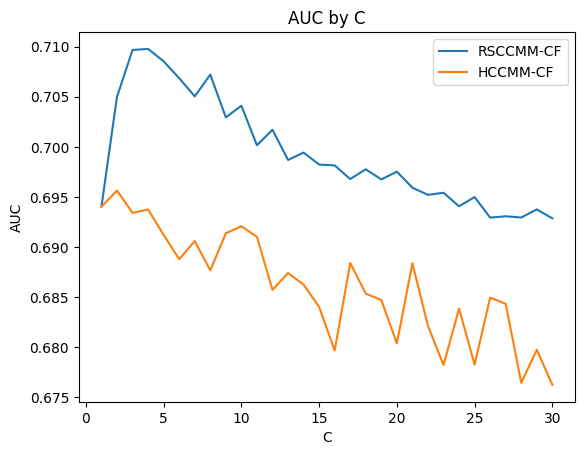

In [ ]:
# csvデータから再現
name = "binary_movie_RSCCMM_HCCMM_compare"
labels=["RSCCMM-CF", "HCCMM-CF"] # TODO: ここちゃんと確認する（HCCMM or RCCMM）
input = pd.read_csv(f'{name}.csv', header=None)

input_x_C = input.values[0] # Cのリスト
input_y_RSCCMM_auc = input.values[1] # RSCCMM-CF results
input_y_RCCMM_auc = input.values[2] # RCCMM-CF resulets

print(input_x_C)
print(input_y_RSCCMM_auc)
print(input_y_RCCMM_auc)

plt.plot(input_x_C, input_y_RSCCMM_auc, label=labels[0])
plt.plot(input_x_C, input_y_RCCMM_auc, label=labels[1])


plt.legend()
plt.title('AUC by C')
plt.xlabel('C')
plt.ylabel('AUC')
plt.savefig(f"{name}.png", format="png", dpi=300)